In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
import pickle
import os
import cv2

In [2]:
from sklearn.utils import shuffle
from sklearn.metrics import classification_report,confusion_matrix, ConfusionMatrixDisplay

In [4]:
import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.metrics import AUC
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2

In [5]:
warnings.simplefilter(action='ignore', category=Warning)

In [6]:
train_path = ('Training/')
test_path = ('Testing/')
image_size = 160

In [7]:
def read_data(path,image_size = 160):
    X = []
    y = []
    labels = os.listdir(path)
    for label in labels:
        for image in tqdm(os.listdir(path + label)):
            img = cv2.imread(os.path.join(path + label,image))
            img = cv2.resize(img,(image_size, image_size))
            X.append(img)
            y.append(label)
    return np.array(X), np.array(y)

In [8]:
X_train, y_train = read_data(train_path)

100%|████████████████████████████████████████████████████████████████████████████████| 827/827 [00:11<00:00, 73.03it/s]


In [9]:
X_test, y_test = read_data(test_path)

100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [00:01<00:00, 51.61it/s]


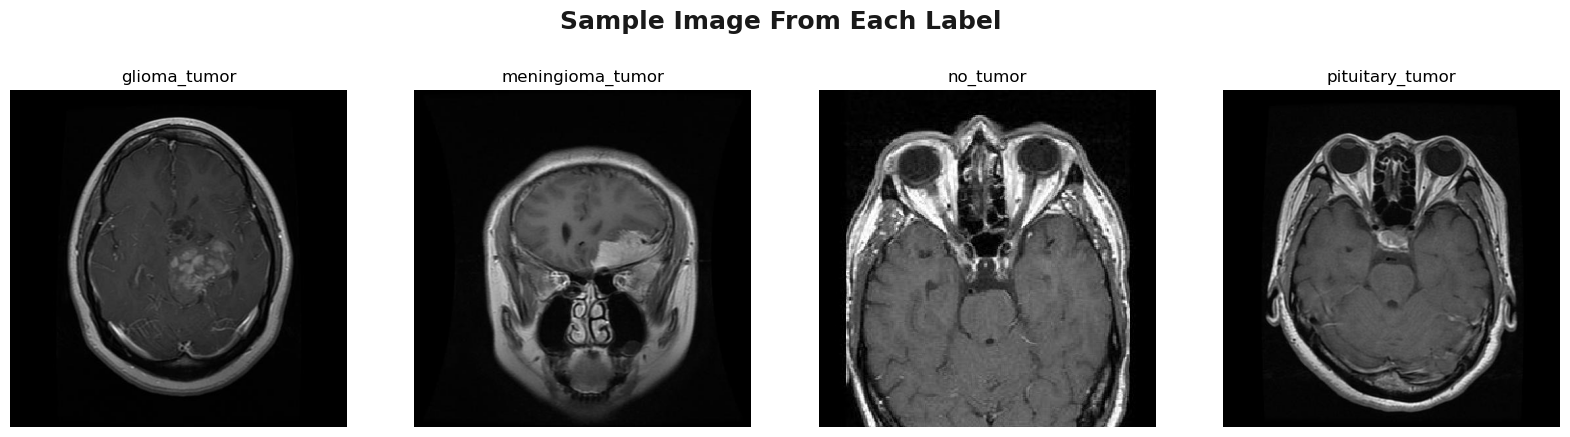

In [10]:
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
         color="black",y=0.61,x=0.4,alpha=0.9)
for count, ele in enumerate(os.listdir(train_path)):
    for j in os.listdir(train_path+ele):
        img= cv2.imread(train_path+ele+'/'+j)
        ax[count].imshow(img)
        ax[count].set_title(ele)
        ax[count].axis('off')
        break

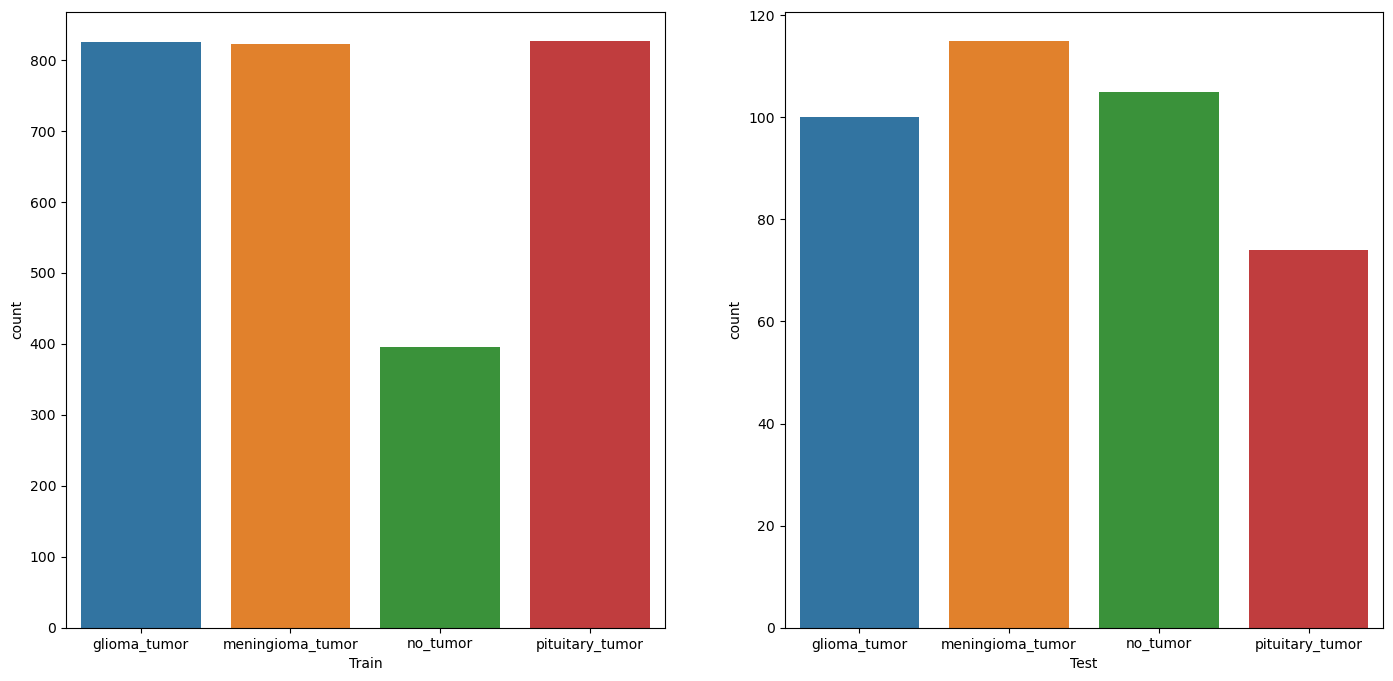

In [11]:
plt.figure(figsize = (17,8));
lis = ['Train', 'Test']
for i,j in enumerate([y_train, y_test]):
    plt.subplot(1,2, i+1);
    sns.countplot(x = j);
    plt.xlabel(lis[i])

In [12]:
X_train, y_train = shuffle(X_train, y_train, random_state=31)

In [13]:
X_test, y_test = shuffle(X_test, y_test, random_state=31)

In [14]:
print(f"X Train shape is --> {X_train.shape}\ny Train shape is --> {y_train.shape}\nX Test shape is --> {X_test.shape}\ny Test shape is --> {y_test.shape}")

X Train shape is --> (2870, 160, 160, 3)
y Train shape is --> (2870,)
X Test shape is --> (394, 160, 160, 3)
y Test shape is --> (394,)


### Data Augmentation

In [15]:
datagen = ImageDataGenerator(
    rotation_range=7, #rotate images
    width_shift_range=0.05,
    height_shift_range=0.05, #shift image in horizontal and vertical
    zoom_range=0.1, #zoom images
    horizontal_flip=True)

datagen.fit(X_train)

### **One-Hot Encoding**

In [16]:
y_train_encoded = pd.get_dummies(y_train)
y_test_encoded = pd.get_dummies(y_test)

### Model

In [17]:
resnet_v2 = InceptionResNetV2(include_top=False,
    weights='imagenet',
    input_shape=(image_size, image_size, 3))

219055592/219055592 [==============================] - 68s 0us/step


In [18]:
model = resnet_v2.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.55)(model)
model = tf.keras.layers.Dense(60,activation='elu',kernel_initializer='GlorotNormal')(model)
model = tf.keras.layers.Dropout(rate=0.3)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=resnet_v2.input, outputs = model)

In [19]:
# opt = Adam(
#     learning_rate=0.000016, beta_1=0.91, beta_2=0.9994,
#     epsilon=1e-08)
model.compile(loss='categorical_crossentropy',optimizer = "Adam", metrics= ['accuracy'])

In [20]:
import datetime
tensorboard = TensorBoard(log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"), histogram_freq=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)
early_stopping_cb=keras.callbacks.EarlyStopping(patience=5,restore_best_weights=True)
checkpoint = ModelCheckpoint("resnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

In [21]:
history = model.fit(X_train,y_train_encoded.to_numpy(),validation_split=0.2, epochs =10, verbose=1, batch_size=32,
                   callbacks=[tensorboard, reduce_lr, early_stopping_cb, checkpoint])

Epoch 1/10
72/72 [==============================] - ETA: 0s - loss: 0.5215 - accuracy: 0.8328 
Epoch 1: val_accuracy improved from -inf to 0.32578, saving model to resnet.h5
72/72 [==============================] - 2130s 28s/step - loss: 0.5215 - accuracy: 0.8328 - val_loss: 9.2986 - val_accuracy: 0.3258 - lr: 0.0010
Epoch 2/10
72/72 [==============================] - ETA: 0s - loss: 0.1918 - accuracy: 0.9421
Epoch 2: val_accuracy improved from 0.32578 to 0.60627, saving model to resnet.h5
72/72 [==============================] - 778s 11s/step - loss: 0.1918 - accuracy: 0.9421 - val_loss: 1.7109 - val_accuracy: 0.6063 - lr: 0.0010
Epoch 3/10
72/72 [==============================] - ETA: 0s - loss: 0.1472 - accuracy: 0.9543
Epoch 3: val_accuracy did not improve from 0.60627
72/72 [==============================] - 736s 10s/step - loss: 0.1472 - accuracy: 0.9543 - val_loss: 3.0563 - val_accuracy: 0.4808 - lr: 0.0010
Epoch 4/10
72/72 [==============================] - ETA: 0s - loss: 0.11

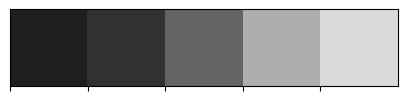

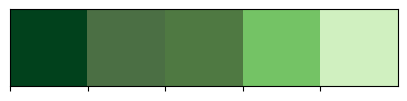

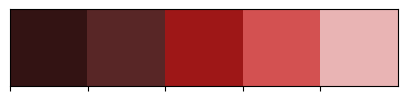

In [22]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

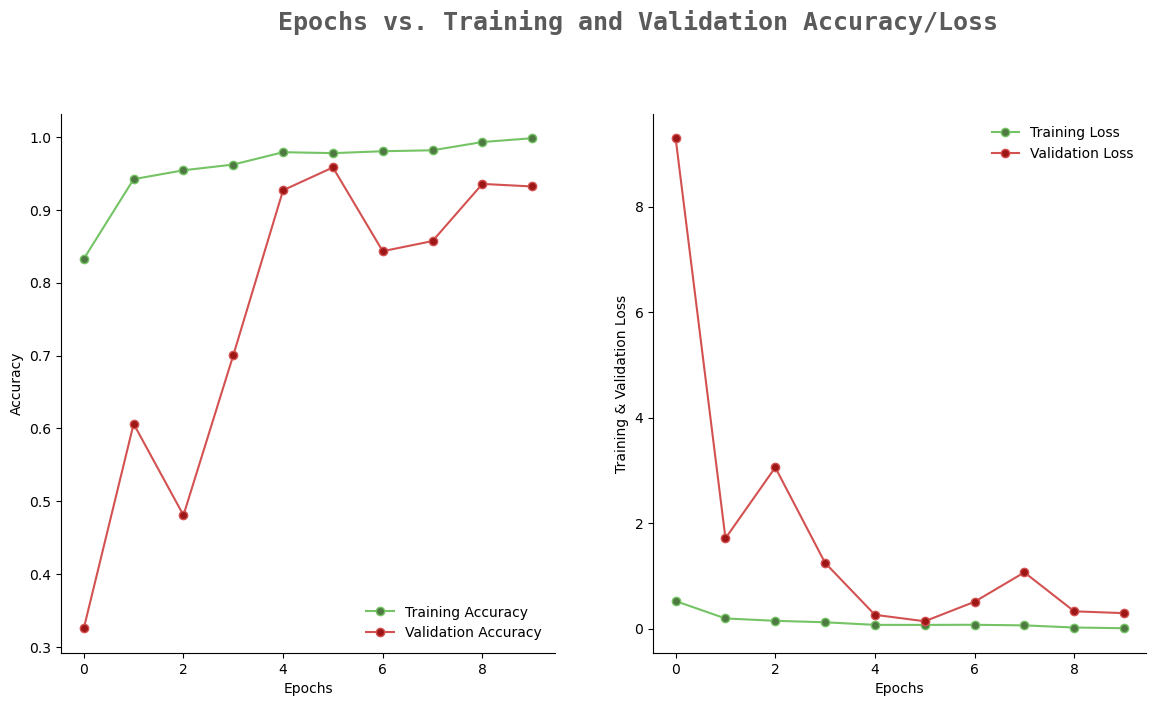

In [23]:
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
epochs_count = [i for i in range(len(train_acc))]

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss', size=18, fontweight='bold',
         fontname='monospace', color=colors_dark[1], y=1, x=0.28, alpha=0.8)

sns.despine()
ax[0].plot(epochs_count, train_acc, marker='o',markerfacecolor=colors_green[2], color=colors_green[3],
           label = 'Training Accuracy')
ax[0].plot(epochs_count, val_acc, marker='o',markerfacecolor=colors_red[2], color=colors_red[3],
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs_count, train_loss, marker='o', markerfacecolor=colors_green[2], color=colors_green[3],
           label='Training Loss')
ax[1].plot(epochs_count, val_loss, marker='o', markerfacecolor=colors_red[2], color=colors_red[3],
           label='Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

In [24]:
loss, accuracy = model.evaluate(X_test,y_test_encoded)

#print accuracy    
print('Accuracy: %f' % (accuracy*100))

13/13 [==============================] - 19s 1s/step - loss: 1.8801 - accuracy: 0.7614
Accuracy: 76.142132


In [25]:
model.optimizer.get_config()  

{'name': 'Adam',
 'weight_decay': None,
 'clipnorm': None,
 'global_clipnorm': None,
 'clipvalue': None,
 'use_ema': False,
 'ema_momentum': 0.99,
 'ema_overwrite_frequency': None,
 'jit_compile': False,
 'is_legacy_optimizer': False,
 'learning_rate': 9e-05,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 1e-07,
 'amsgrad': False}

In [26]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test_encoded.to_numpy(),axis=1)

13/13 [==============================] - 25s 1s/step


In [27]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.87      0.26      0.40       100
           1       0.71      0.95      0.81       115
           2       0.73      0.99      0.84       105
           3       0.91      0.82      0.87        74

    accuracy                           0.76       394
   macro avg       0.80      0.76      0.73       394
weighted avg       0.79      0.76      0.72       394



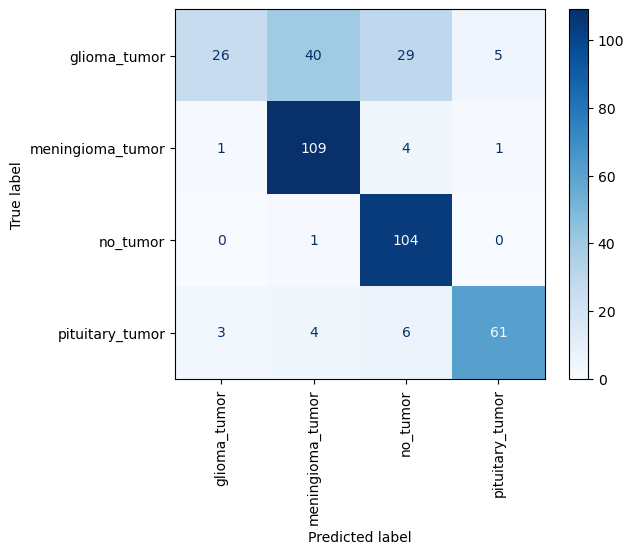

In [28]:
ConfusionMatrixDisplay.from_predictions(y_test_new, pred, display_labels=y_test_encoded.columns, 
                                        cmap='Blues', xticks_rotation="vertical")
plt.show()

### Read the Best Model

In [29]:
best_model = keras.models.load_model('resnet.h5')

In [30]:
loss, accuracy = best_model.evaluate(X_test,y_test_encoded)

#print accuracy    
print('Accuracy: %f' % (accuracy*100))

13/13 [==============================] - 25s 2s/step - loss: 1.9332 - accuracy: 0.7513
Accuracy: 75.126904


In [31]:
pred = best_model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test_encoded.to_numpy(),axis=1)

13/13 [==============================] - 25s 2s/step


In [32]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       1.00      0.27      0.43       100
           1       0.64      0.99      0.78       115
           2       0.75      0.99      0.86       105
           3       0.98      0.69      0.81        74

    accuracy                           0.75       394
   macro avg       0.84      0.74      0.72       394
weighted avg       0.83      0.75      0.72       394



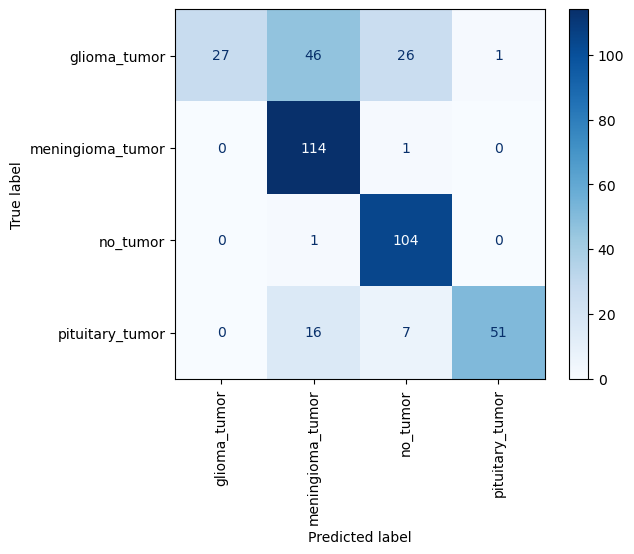

In [33]:
ConfusionMatrixDisplay.from_predictions(y_test_new, pred, display_labels=y_test_encoded.columns, 
                                        cmap='Blues', xticks_rotation="vertical")
plt.show()